# [Fig. 9] Schematic for the Plume Distance

Reviewer 1: 
*I think it would help improve the understanding and adoption of the plume distance metric if the authors included a schematic/cartoon that illustrates and combines more steps of the process than is currently shown in Figs 6-8. For example, the schematic could show the time series (or part of the time series) from Fig 6, then draw the tube around a trace, then show what distance you're calculating with respect to the tube and the ensembles, then how that connects to the ideas shown in Figs 7 and 8 (also made more feasible if you only worry about plotting the L1 norm from Fig 7). This schematic then might either replace or supplement Figs 6-8. Even though I'm already familiar with many of the concepts discussed in the paper, I found myself needing to make my own little cartoon to make sure I understood what was going on. This is particularly the case when the authors get to the ideas of intra- vs inter-ensemble distances*.

In [1]:
%load_ext autoreload
%autoreload 2
import pens
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
pens.set_style('journal_nogrid')

## Loading data

### LMRonline:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'LMR online'}, xlabel='time [yrs]', ylabel='GMST [°C]'>)

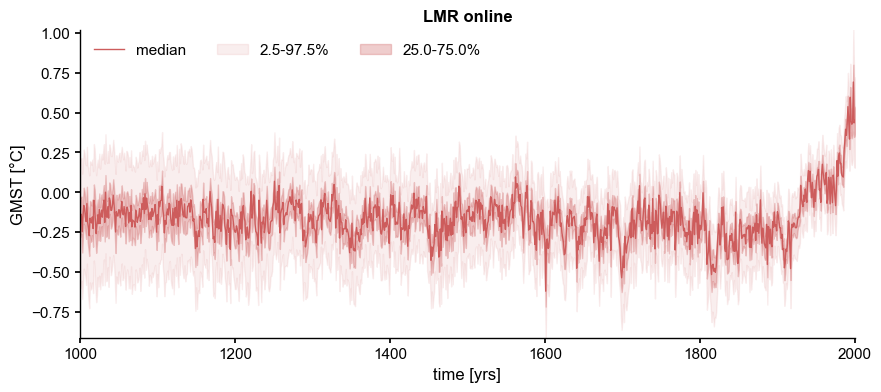

In [2]:
ens_on = pens.EnsembleTS().load_nc('../data/gmt_MCruns_ensemble_full_LMRonline.nc', var='glob_mean', time_name='year')
ens_on.label = 'LMR online'
ens_on.value_name = 'GMST'
ens_on.value_unit = '\N{DEGREE SIGN}C'
ens_on.time_unit = 'yrs'
ens_on.plot_qs()

### LMRv2.1

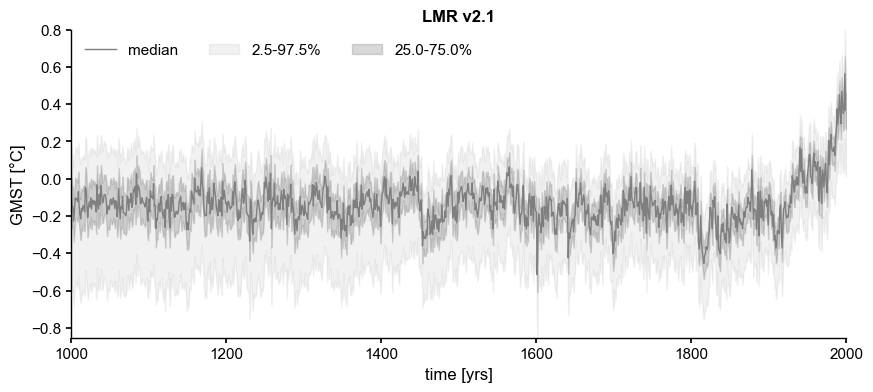

In [3]:
path = '../data/gmt_MCruns_ensemble_full_LMRv2.1.nc'
LMR = pens.EnsembleTS().load_nc(path, var='gmt')
common_time = [1000, 2000]
ens_off  = LMR.slice(common_time)
ens_off.label = 'LMR v2.1'
ens_off.value_name = 'GMST'
ens_off.value_unit = '\N{DEGREE SIGN}C'
ens_off.time_unit = 'yrs'
fig, ax = ens_off.plot_qs(color = 'tab:gray')

In [4]:
offset = 0.75
ens_o2000 = ens_on.subsample(nsamples=ens_off.nEns) - offset

### Resample according to a power law

In [5]:
ens_off_pl = ens_off.random_paths(model='power-law',param=0.92,p=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2652.11it/s]


In [6]:
ens_off_pl.value.shape

(1001, 2000)

Computing inter-ensemble distance: 100%|██████████| 2000/2000 [00:14<00:00, 136.82it/s]


<Axes: ylabel='Count'>

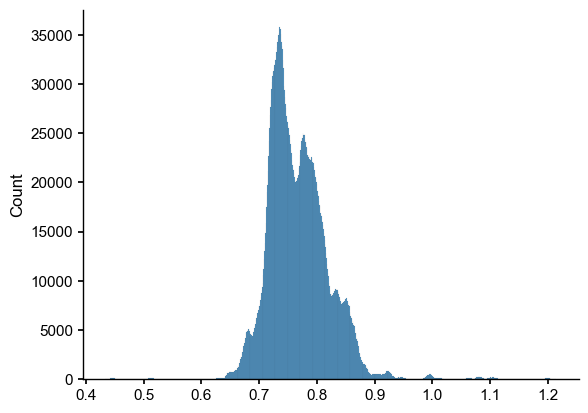

In [7]:
inter_dist = ens_o2000.distance(ens_off_pl)
sns.histplot(inter_dist)

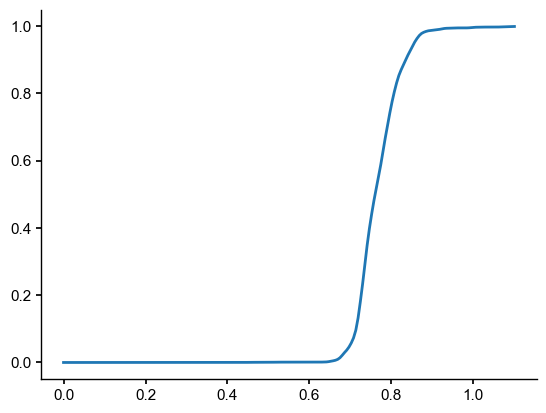

In [8]:
e = np.linspace(0,1.1,num=200)
prob = ens_o2000.proximity_prob(y=ens_off_pl, eps=e, dist=inter_dist)
plt.plot(e,prob)

 ### Find the plume distance

In [9]:
delta_eps  = ens_o2000.plume_distance(ens_off_pl,dist=inter_dist)

Computing inter-ensemble distance: 100%|██████████| 2000/2000 [00:14<00:00, 139.30it/s]


In [10]:
delta_eps

(0.7601925753950028, 0.06606677293571162)

## Plot schematic

(1100.0, 1300.0)

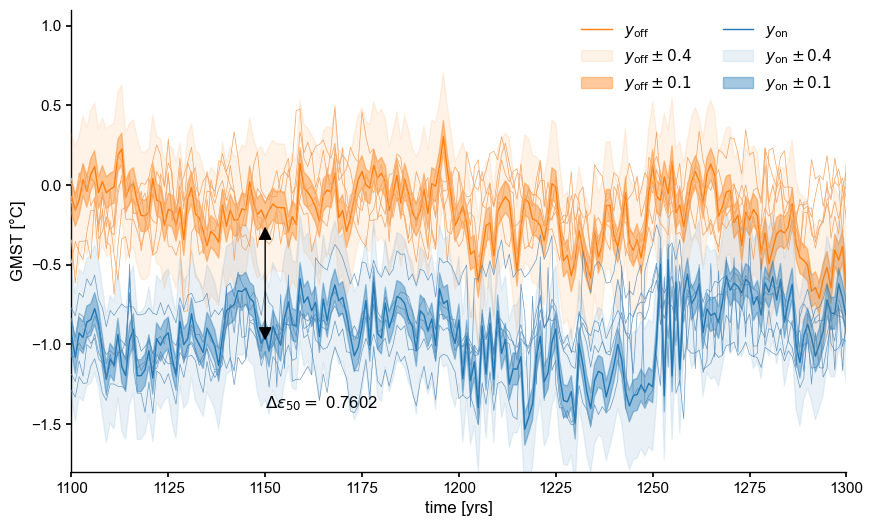

In [11]:
import matplotlib.patches as patches

seed=8
alpha_max=0.5
fig, ax = plt.subplots(figsize=(10,6))
# offline target
ens_off_target = ens_off_pl.subsample(1,seed=seed)
color_off = 'C1'
ens_off_target.plot(color = color_off,ax=ax, label = r'$y_\mathrm{off}$', zorder=99)
y_off = np.squeeze(ens_off_target.value)
for eps in [0.4, 0.1]:
    ax.fill_between(ens_off_target.time, y_off-eps, y_off+eps,
                    color=color_off, alpha=alpha_max-eps, 
                    label=rf'$y_\mathrm{{off}} \pm {eps}$', zorder=90)
ens_off_pl.plot_traces(color = 'sandybrown',alpha=1, label='LMRv2.1',ax=ax)

# online target
ens_on_target = ens_o2000.subsample(1,seed=seed)
color_on = 'C0'
ens_on_target.plot(color = color_on,ax=ax, label = r'$y_\mathrm{on}$')
y_on = np.squeeze(ens_on_target.value)
t = ens_on_target.time
for eps in [0.4, 0.1]:
    ax.fill_between(t, y_on-eps, y_on+eps,
                    color=color_on, alpha=alpha_max-eps, 
                    label=rf'$y_\mathrm{{on}} \pm {eps}$', zorder=90)
ens_o2000.plot_traces(color='steelblue',alpha=0.8,ax=ax,label='LMRonline - 0.75')


ax.legend(loc = 'upper right', ncol = 2)

# add plume distance
yr = -1.4; xr = 1150
ax.text(x=xr, y=yr,s=fr'$\Delta \epsilon_{{50}} = $ {delta_eps[0]:.4f}')
xr_idx = xr-t.min()-1
pa = patches.FancyArrowPatch((xr, y_on[xr_idx]+offset), (xr, y_on[xr_idx]),
                             arrowstyle='<|-|>', mutation_scale=20, 
                             color='k',zorder=99)
ax.add_patch(pa)

#ax.set_title("Intra vs Inter-ensemble distance", fontweight = 'bold')
ax.set_ylim(-1.8,1.1)
ax.set_xlim(1100,1300)

## Proximity Probability

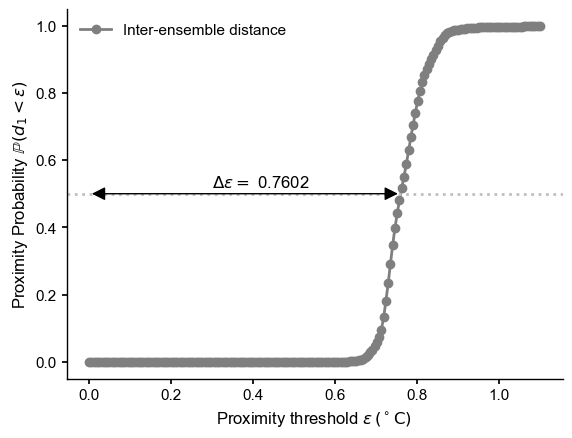

In [12]:
fig, ax = plt.subplots()
inter_col = "tab:gray"
ax.plot(e,prob,label='Inter-ensemble distance',
        marker='o',color=inter_col)  
ax.legend()
ax.axhline(y=0.5,color='silver',ls=':')
ax.text(x=0.3, y=0.52,s=fr'$\Delta \epsilon = $ {delta_eps[0]:.4f}')
pa = patches.FancyArrowPatch((0, .5), (delta_eps[0], .5), arrowstyle='<|-|>',
                             mutation_scale=20, color='k',zorder=99)
ax.add_patch(pa)
ax.set_xlabel(r'Proximity threshold $\epsilon \, ({}^\circ \mathrm{C})$ ')
ax.set_ylabel(r'Proximity Probability $\mathbb{P}(d_1 < \epsilon)$') 
#ax.set_title("Proximity Probability", fontweight = 'bold')

## Proximity Densities

In [13]:
LMRon_intra_dist = ens_o2000.distance()

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:05<00:00, 362266.71it/s]


In [14]:
LMRoff_intra_dist_pl = ens_off_pl.distance()

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:08<00:00, 236841.75it/s]


Now let's plot these 3 quantities on the same graph (the plume distance is the dashed line):

Text(0.5, 0, 'Proximity threshold $\\epsilon \\, ({}^\\circ \\mathrm{C})$ ')

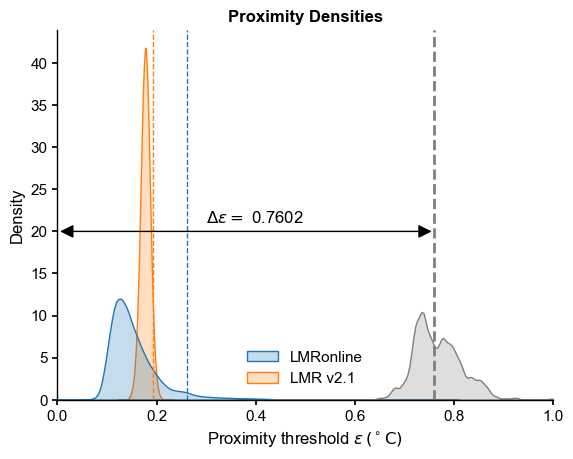

In [15]:
data = {'LMRonline': LMRon_intra_dist,
        'LMR v2.1': LMRoff_intra_dist_pl}
df = pd.DataFrame(data)
fig, ax  = plt.subplots()
sns.kdeplot(df, fill=True, ax=ax, common_norm=False)
sns.kdeplot(inter_dist, fill=True, ax=ax, common_norm=False, color=inter_col)
ax.axvline(x=delta_eps[0],color=inter_col, linestyle="--",label='plume distance')
x_max = 1.0
ax.set_xlim(0,x_max)
# add delta eps
ax.text(x=0.3, y=21,s=fr'$\Delta \epsilon = $ {delta_eps[0]:.4f}')
pa = patches.FancyArrowPatch((0, 20), (delta_eps[0], 20), arrowstyle='<|-|>',
                             mutation_scale=20, color='k',zorder=99)
ax.add_patch(pa)
# add quantiles
LMRon_q95 = np.quantile(LMRon_intra_dist,0.95)
ax.axvline(x=LMRon_q95,color="C0", linestyle="--",linewidth=1)
LMRoff_q95 = np.quantile(LMRoff_intra_dist_pl,0.95)
ax.axvline(x=LMRoff_q95,color="C1", linestyle="--",linewidth=1)
ax.set_title("Proximity Densities", fontweight = 'bold')
ax.set_xlabel(r'Proximity threshold $\epsilon \, ({}^\circ \mathrm{C})$ ')

## Combine into one

Text(0.5, 0, 'Proximity threshold $\\epsilon \\, ({}^\\circ \\mathrm{C})$ ')

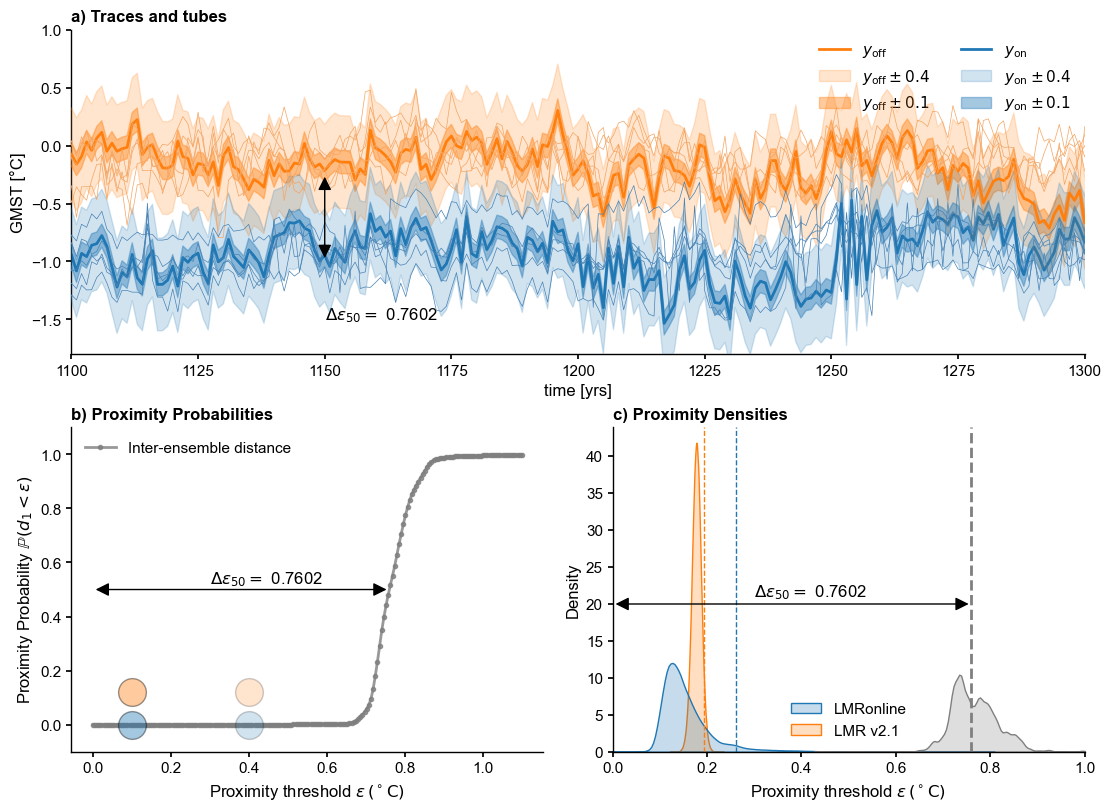

In [17]:
fig, axs = plt.subplot_mosaic([['a)', 'a)'], ['b)', 'c)']],
                              layout='constrained', figsize=(11,8))
eps_range = [0.4, 0.1]
alpha_range = [0.2, 0.4]
# a)
ens_off_target = ens_off_pl.subsample(1,seed=seed)
color_off = 'C1'
ens_off_target.plot(color = color_off,ax=axs['a)'],
                    linewidth=2, label = r'$y_\mathrm{off}$', zorder=99)
y_off = np.squeeze(ens_off_target.value)
for eps, alp in zip(eps_range, alpha_range):
    axs['a)'].fill_between(ens_off_target.time, y_off-eps, y_off+eps,
                    color=color_off, alpha=alp, 
                    label=rf'$y_\mathrm{{off}} \pm {eps}$', zorder=90)
ens_off_pl.plot_traces(color = 'sandybrown',alpha=1, label='LMRv2.1',ax=axs['a)'])

# online target
ens_on_target = ens_o2000.subsample(1,seed=seed)
color_on = 'C0'
ens_on_target.plot(color = color_on, linewidth=2, ax=axs['a)'], label = r'$y_\mathrm{on}$')
y_on = np.squeeze(ens_on_target.value)
t = ens_on_target.time
for  eps, alp in zip(eps_range, alpha_range):
    axs['a)'].fill_between(t, y_on-eps, y_on+eps,
                    color=color_on, alpha=alp, 
                    label=rf'$y_\mathrm{{on}} \pm {eps}$', zorder=90)
ens_o2000.plot_traces(color='steelblue',alpha=1, ax=axs['a)'],label='LMRonline - 0.75')
axs['a)'].legend(loc = 'upper right', ncol = 2)

# add plume distance
yr = -1.5; xr = 1150
axs['a)'].text(x=xr, y=yr,s=fr'$\Delta \epsilon_{{50}} = $ {delta_eps[0]:.4f}')
xr_idx = xr-t.min()-1
pa = patches.FancyArrowPatch((xr, y_on[xr_idx]+offset), (xr, y_on[xr_idx]),
                             arrowstyle='<|-|>', mutation_scale=20, 
                             color='k',zorder=99)
axs['a)'].add_patch(pa)
axs['a)'].set_ylim(-1.8,1)
axs['a)'].set_xlim(1100,1300)
axs['a)'].set_title("a) Traces and tubes", fontweight = 'bold', loc='left')
# b) 
inter_col = "tab:gray"
axs['b)'].plot(e,prob,label='Inter-ensemble distance', 
               marker='.',color=inter_col,alpha=0.8)
for eps, alp in zip(eps_range, alpha_range):    
    axs['b)'].plot(eps,0, marker='o',color=color_on, alpha = alp,
                   markersize=20, markeredgecolor='k')
    axs['b)'].plot(eps,0.12, marker='o',color=color_off, alpha = alp,
                   markersize=20, markeredgecolor='k')
axs['b)'].legend()
axs['b)'].text(x=0.3, y=0.52,s=fr'$\Delta \epsilon_{{50}} = $ {delta_eps[0]:.4f}')
pa = patches.FancyArrowPatch((0, .5), (delta_eps[0], .5), arrowstyle='<|-|>',
                             mutation_scale=20, color='k',zorder=99)
axs['b)'].add_patch(pa)
axs['b)'].set_xlabel(r'Proximity threshold $\epsilon \, ({}^\circ \mathrm{C})$ ')
axs['b)'].set_ylabel(r'Proximity Probability $\mathbb{P}(d_1 < \epsilon)$') 
axs['b)'].set_title("b) Proximity Probabilities", fontweight = 'bold', loc='left')
axs['b)'].set_ylim(-0.1,1.1)
# proximity densities
sns.kdeplot(df, fill=True, ax=axs['c)'], common_norm=False)
sns.kdeplot(inter_dist, fill=True, ax=axs['c)'], common_norm=False, color=inter_col)
axs['c)'].axvline(x=delta_eps[0],color=inter_col, linestyle="--",label='plume distance')
axs['c)'].set_xlim(0,1)
# add delta eps
axs['c)'].text(x=0.3, y=21,s=fr'$\Delta \epsilon_{{50}} = $ {delta_eps[0]:.4f}')
pa = patches.FancyArrowPatch((0, 20), (delta_eps[0], 20), arrowstyle='<|-|>',
                             mutation_scale=20, color='k',zorder=99)
axs['c)'].add_patch(pa)
# add quantiles
LMRon_q95 = np.quantile(LMRon_intra_dist,0.95)
axs['c)'].axvline(x=LMRon_q95,color="C0", linestyle="--",linewidth=1)
LMRoff_q95 = np.quantile(LMRoff_intra_dist_pl,0.95)
axs['c)'].axvline(x=LMRoff_q95,color="C1", linestyle="--",linewidth=1)
axs['c)'].set_title("c) Proximity Densities", fontweight = 'bold', loc='left')
axs['c)'].set_xlabel(r'Proximity threshold $\epsilon \, ({}^\circ \mathrm{C})$ ')